In [1]:
import os
from os.path import basename, dirname
from shutil import copyfile

import json
import pickle
from collections import OrderedDict

import torch

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import scipy.stats as ss
import seaborn as sns

In [3]:
os.chdir("..")

In [4]:
np.random.seed(21)

In [5]:
model_name  = 'concat60'
savedir = f"experiments/en_et_{model_name}/internals/sent_means_train.pkl"
with open(savedir, 'rb') as f:
    data_encoded = pickle.load(f)

In [6]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [7]:
all_encoded = []
all_labels = []
for d, v in data_encoded.items():
    all_encoded.extend(data_encoded[d])
    all_labels.extend([d] * len(data_encoded[d]))   
    
all_encoded = np.array(all_encoded)
all_labels = np.array(all_labels)

In [8]:
%%time

#indices = np.arange(all_encoded.shape[0])
#np.random.shuffle(indices)

#hiddens_shuff = all_encoded[indices]
#labels_shuff = all_labels[indices]

kmeans = KMeans(n_clusters=4, random_state=0, n_init=5).fit(all_encoded)

conf_matrix = pd.crosstab(all_labels, kmeans.labels_)
corr_k = cramers_corrected_stat(conf_matrix)

print(f"Corr k: {corr_k}")
print(conf_matrix)

savedir = f"experiments/en_et_{model_name}/internals"
if not os.path.isdir(savedir):
    os.mkdir(savedir)
    
    
print(f"Saving to {savedir}/kmeans_train.pkl")
with open(f'{savedir}/kmeans_train.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

i = 0
for k,v in data_encoded.items():
    fn = f"nmt_labels-{k}.txt"
    np.savetxt(f"{savedir}/{fn}", kmeans.labels_[i:i+len(v)].astype(int), fmt="%i")
    i += len(v)

Corr k: 0.7032141185702107
col_0               0       1       2       3
row_0                                        
EMEA             5472    5342  307261   92465
Europarl        44627  446884    1578    7077
JRC-Acquis       4828  374305    9708  111179
OpenSubtitles  424246   13635     995   62000
Saving to experiments/en_et_concat60/internals/kmeans_train.pkl
CPU times: user 9min 19s, sys: 11.1 s, total: 9min 30s
Wall time: 1min 23s


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

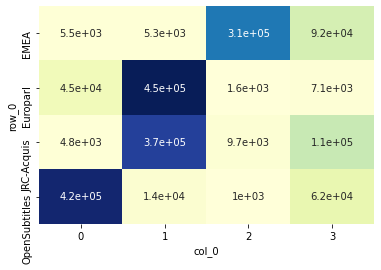

In [9]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

In [10]:
data_raw = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/fairseq-data-en-et-{domain_name}-ft/train.en" # TODO: change to train
    with open(fn) as f:
        data_raw[domain_name] = [l[:-1] for l in f.readlines()]

In [11]:
all_raw = []
for d, v in data_raw.items():
    print(d)
    all_raw.extend(data_raw[d])

Europarl
OpenSubtitles
JRC-Acquis
EMEA


In [13]:
len(all_raw)

1911602

In [15]:
len(kmeans.labels_)

1911602

{0, 1, 2, 3}

In [17]:
from collections import defaultdict

In [18]:
data_by_clust = defaultdict(list)
for l, s in zip(kmeans.labels_, all_raw):
    data_by_clust[l].append(s)

In [20]:
for k,v in data_by_clust.items():
    fn = f"experiments/data-clust-nmt/nmt_clust_sent-{k}.txt"
    with open(fn, 'w') as f:
        for s in v:
            f.write(s + '\n')

# Bert sent clusters

In [10]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.train.clusters_sent_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]

In [11]:
labels_bert_all = []
labels_bert_all_true = []
for k,v in labels_bert.items():
    labels_bert_all.extend(v)
    labels_bert_all_true.extend([k] * len(v))

In [12]:
conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.24168047830449288
col_0               0       1      2       3
row_0                                       
EMEA            72707  140991  39598  157244
Europarl       166334  177192  56586  100054
JRC-Acquis     162534  163134  29920  144432
OpenSubtitles   46245   50394  84391  319846


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

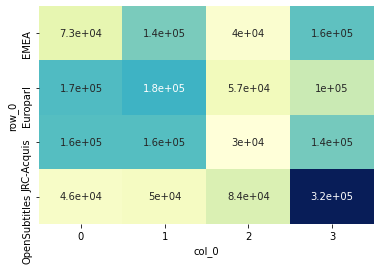

In [13]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# Bert doc clusters

In [14]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]

In [15]:
labels_bert_all = []
labels_bert_all_true = []
for k,v in labels_bert.items():
    labels_bert_all.extend(v)
    labels_bert_all_true.extend([k] * len(v))

In [16]:
conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.8089680719230101
col_0               0       1       2       3
row_0                                        
EMEA            42870  344373    3200   20097
Europarl          521    3372  493821    2452
JRC-Acquis     279334  152902   61959    5825
OpenSubtitles    1001    9881     899  489095


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

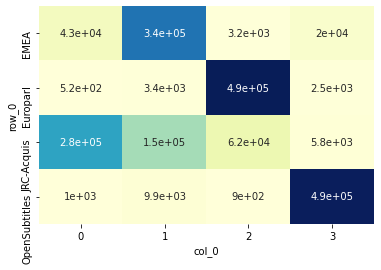

In [17]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# Rand clusters

In [18]:
from random import sample

In [19]:
labels_rand = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust-new/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_rand[domain_name] = [sample([0,1,2,3], 1)[0] for l in f.readlines()]

In [20]:
labels_rand_all = []
labels_rand_all_true = []
for k,v in labels_rand.items():
    labels_rand_all.extend(v)
    labels_rand_all_true.extend([k] * len(v))

In [21]:
conf_matrix = pd.crosstab(np.array(labels_rand_all_true), np.array(labels_rand_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.0
col_0               0       1       2       3
row_0                                        
EMEA           102320  102765  102762  102693
Europarl       124741  124613  125804  125008
JRC-Acquis     125047  125288  124874  124811
OpenSubtitles  125142  125495  124959  125280


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

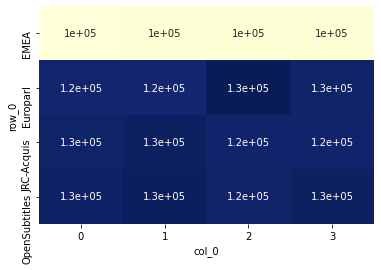

In [22]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

In [23]:
i = 0
for k,v in data_raw.items():
    fn = f"rand_labels-{k}.txt"
    np.savetxt(f"{savedir}/{fn}", np.array(labels_rand_all)[i:i+len(v)].astype(int), fmt="%i")
    i += len(v)

NameError: name 'data_raw' is not defined